# PyTorch tutorial
Based on the book [Deep Learning with Pytorch](https://pytorch.org/assets/deep-learning/Deep-Learning-with-PyTorch.pdf), this is mostly focused on the PyTorch API and Part I of the book and not so much on giving an intro to deep learning. Refer to the book and its corresponding [code on Github](https://github.com/deep-learning-with-pytorch/dlwpt-code/tree/master/) for more detail.

# Overview

PyTorch is a library for Python programs that facilitates building deep learning projects. It emphasizes flexibility and allows deep learning models to be expressed in idiomatic Python. PyTorch operates in eager mode by default. That is, whenever an instruction involing PyTorch is executed by the Python interpreter, the corresponding operation is immediately carried out by the underlying C++ or CUDA implementation. PyTorch also provides a way to compile models of ahead of time through TorchScipt. Using TorchScript, PyTorch can serialize a model into a set of instructions that can be invoked independently from Python, such as with ONNX. This is similar to how Tensorflow 1.0 was built in that the user had to define a computational graph that they later executed.

In [1]:
import torch

In [2]:
torch.cuda.is_available()

True

# Data
We need to convert each sample from our data into something PyTorch can actually handle: tensors or multidimensional arrays. In the context of deep learning, tensors refer to the generalization of vectors and matrices to an arbitrary number of dimensions. They are similar to Numpy arrays and can be indexed in the same way but offer the ability to perform computation on GPUs. All items in a tensor must be numbers of the same type; supported types are defined in [torch.dtype](https://pytorch.org/docs/stable/tensor_attributes.html#torch.torch.dtype) with the default being `torch.float32`. Both Numpy arrays and PyTorch tensors are allocated as contiguous blocks of memory containing C numeric types as opposed to Python lists which are collections of Python objects individually allocated throughout memory (see figure 3.3 in the book). Memory footprint is managed by `torch.Storage` instances storing tensors in memory as 1d contiguous blocks, improving data locality and performance. 

`torch.save` and `torch.load` operate using the pickle protocol and can be used to save and load tensors. For interoperability, hdf5 is also supported.

Images are usually stored in a volume (num images x num rows x num cols). Similarly, time series data are stored in a volume where one dimension corresponds a unit of time the data is stored in (t x num rows x num cols).

Neural networks take tensors as input and produce tensors as outputs. In
fact, all operations within a neural network and during optimization are operations
between tensors, and all parameters (for example, weights and biases) in a neural
network are tensors.

In [3]:
a = torch.ones(3, 3, dtype=torch.int)
b = torch.ones(3, 3)

In [4]:
a[0,0]

tensor(1, dtype=torch.int32)

In [5]:
b.dtype

torch.float32

In [6]:
a.shape

torch.Size([3, 3])

We've constructed two 3x3 tensors of 1s and when added we should get a 3x3 tensor of 2s. Slicing and reshaping tensors can be done with `torch.view`. This avoids copying such that the view shares the same underlying data.

In [7]:
a + b

tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]])

In [8]:
b.view(-1, 9)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1.]])

We can add an extra dimension to a tensor using the `None` indexing or the `unsqueeze` function

In [9]:
a[None]

tensor([[[1, 1, 1],
         [1, 1, 1],
         [1, 1, 1]]], dtype=torch.int32)

In [10]:
a.unsqueeze(0).shape

torch.Size([1, 3, 3])

The tensor API has many operations in the `torch` [module](https://pytorch.org/docs/stable/torch.html) but can also be called as methods of a tensor object. For example, with `unsqueeze` above we called it as a method of tensor `a` but we can also call it through the `torch` module. There are a number of operations though that exist only as methods of the tensor object and they operate inplace; they're identified by a trailing underscore.

In [11]:
torch.unsqueeze(a, 0)

tensor([[[1, 1, 1],
         [1, 1, 1],
         [1, 1, 1]]], dtype=torch.int32)

In [12]:
a.zero_()

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]], dtype=torch.int32)

In [13]:
a

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]], dtype=torch.int32)

Above, our tensors are stored on the CPU. We can also transfer or create them on the GPU

In [14]:
points_gpu = torch.tensor([[4.0, 1.0], [5.0, 3.0], [2.0, 1.0]], device='cuda')

In [15]:
b.to(device="cuda:0")

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], device='cuda:0')

Now both `b` and `points_gpu` are in GPU RAM and we can start seeing performance optimizations with operations on the GPU. We can also go back and forth between Pytorch and Numpy. If we were to convert a PyTorch tensor stored on the GPU to numpy, it would make a copy over to CPU, however converting a tensor on CPU RAM to numpy comes at no cost since they both use the same underlying buffer for storage. It's good to note that numpy arrays are stored as `torch.float64` when converted so it's usually best to convert to `torch.float32` to avoid memory footprint.

In [16]:
import numpy as np

In [17]:
np_array = np.random.randn(2,2)

In [18]:
torch_from_np = torch.from_numpy(np_array)

In [19]:
torch_from_np.to(dtype=torch.float32)

tensor([[-1.4850, -0.8921],
        [-0.4044, -0.0816]])

In [20]:
torch_from_np.numpy()

array([[-1.48500536, -0.89214756],
       [-0.40442433, -0.08158075]])

We can also name each dimension within tensors so that that they are easier to keep track. For example if we have 2 4x4 images with 3 channels: RGB. Funtions accepting dimension arguments can now take names instead. It's still an experimental feature so we won't go too in depth

In [21]:
imgs = torch.randn(2, 3, 4, 4, names=["batch", "channels", "rows", "columns"])

/home/ubuntu/miniconda3/envs/pytorch_37/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1609143291274/work/c10/core/TensorImpl.h:890.)
  """Entry point for launching an IPython kernel.


In [22]:
imgs.shape, imgs.names

(torch.Size([2, 3, 4, 4]), ('batch', 'channels', 'rows', 'columns'))

In [23]:
imgs.sum("batch")

tensor([[[-0.6343,  1.5833, -0.0329,  0.1315],
         [-1.7858,  1.7780, -0.3074, -0.9811],
         [ 0.0191, -1.0221, -1.0766,  1.0057],
         [ 2.2630,  0.5581, -0.8069,  1.1776]],

        [[ 0.4011,  0.6641,  1.8183,  0.6076],
         [ 1.2858,  2.3704, -0.4399,  1.4958],
         [ 0.2001,  1.7927,  2.6371,  2.9855],
         [-2.7196,  0.7211,  0.2021, -0.4641]],

        [[ 0.6448,  0.2991, -1.6020,  1.5254],
         [-0.1349,  0.6821,  0.4125, -2.0789],
         [-0.5938,  0.6197, -0.8342, -0.6182],
         [-1.7776, -0.5511, -1.2878,  0.1249]]],
       names=('channels', 'rows', 'columns'))

## Datasets

This bridge between our custom data (in whatever format it might be) and a standardized PyTorch tensor is the `Dataset` class PyTorch provides in `torch.utils.data`. Simply put, it's object that is required to implement two methods: `__len__` and `__getitem__`. The former should return the number of items in the dataset; the latter should return the item, consisting of a sample and its corresponding label (an integer index).

In [24]:
from torchvision import datasets

In [25]:
cifar10 = datasets.CIFAR10(".", train=True, download=True)

Files already downloaded and verified


In [26]:
len(cifar10)

50000

In [27]:
img, label = cifar10[3]
img, label

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F465D7E0ED0>, 4)

## DataLoader

`DataLoader` is another class provided under `torch.utils.data` that helps with shuffling and organizing data into minibatches.
* lets us sample data with various sampling strategies. 
* implements `__next__` so it can be iterated over and integrated directly in our training loop
* provides functionality to load data in parallel by spawning child processes in the background so that it’s ready and waiting for the training loop as soon as the loop can use it.

In [28]:
train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64, shuffle=True)

In [29]:
train_loader

# Learning

In [30]:
%matplotlib inline
from matplotlib import pyplot as plt

## Estimating parameters

To get started, we'll take some input temperature data in celcius `t_c` and some output data in unknown units `t_u`. We'll assume there exists a linear relationship between the input and output and we'd like to learn their relationship by estimating paremeters of a linear model. That is we assume we can multiply `t_u` by some amount `w` and add a constant `b` to get `t_c`: `t_c = w*t_u + b`. We'll estimate parameters `w` (weights) and `b` (biases) since they are not known. If we choose some values for `w` and `b`, how do we know how good of an estimate they are? We'll use a loss function to measure the error between our predictions `t_p` and desired outputs `t_c`: `(t_p - t_c)^2` (see section 5.3 for why we use this loss).

In [31]:
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4])

In [32]:
def model(t_u, w, b):
    return w * t_u + b

In [33]:
# initialize the parameters and invoke the model
w = torch.randn(())
b = torch.randn(())
t_p = model(t_u, w, b)
t_p

tensor([11.1664, 17.0082, 17.6733, 24.5272, 17.1238, 14.9838, 10.6459,  7.1467,
        14.8392, 18.3095, 20.6231])

In [34]:
def mse(t_p, t_c):
    """Loss function: mean squared error"""
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [35]:
# calculate the loss function
mse(t_p, t_c)

tensor(47.0433)

We can keep randomly choosing values of `w` and `b` until we find values where the loss function is small enough but that's inefficient. Instead we'll use an iterative procedure to update our parameters called gradient descent. We'll look at a small neighborhood around the current value of each parameter and find the direction where the loss is decreasing the most using the derivative. In a model with two or more parameters like the one we’re dealing with, we compute the individual derivatives of the loss with respect to each parameter and put them in a vector of derivatives: the gradient `[dloss/dw, dloss/db]`. In order to compute this vector of derivatives we'll use the chain rule to compute `dloss/dw = dloss/dmodel * dmodel/dw` and `dloss/db = dloss/dmodel * dmodel/db`.

In [36]:
def dloss_dmodel(t_p, t_c):
    """Derivative of loss function (t_p - t_c)^2
    with respect to the output of the model t_p"""
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)
    return dsq_diffs

def dmodel_dw(t_u, w, b):
    """Derivate of the model w * t_u + b
    with respect to w"""
    return t_u

def dmodel_db(t_u, w, b):
    """Derivate of the model w * t_u + b
    with respect to b"""
    return 1.0

def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_dmodel(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    """Typically the training loop is implemented as a standard Python for loop. 
    Pytorch lightning gives more high level API on top of pytorch for training
    
    n_epochs: number of epochs - a training iteration that results in updating parameters for all training samples
    learning_rate: scaling factor that determines how much we update our weights by
    """
    for epoch in range(1, n_epochs + 1):
        w, b = params
        
        # forward pass
        t_p = model(t_u, w, b)
        loss = mse(t_p, t_c)
        # backward pass - backpropagating derivatives
        grad = grad_fn(t_u, t_c, t_p, w, b)
        # update parameters
        params = params - learning_rate * grad
        
        if epoch % 100 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss))) # <3>
            
    return params

In [37]:
# simple normalization to prevent bias and weights from receiving different relative updates
t_un = 0.1*t_u
w_star, b_star = training_loop(n_epochs = 1000, learning_rate = 1e-2, 
                               params = torch.tensor([1.0, 0.0]),
                               t_u = t_un,  
                               t_c = t_c)
w_star, b_star

Epoch 100, Loss 22.148710
Epoch 200, Loss 16.608067
Epoch 300, Loss 12.664559
Epoch 400, Loss 9.857804
Epoch 500, Loss 7.860115
Epoch 600, Loss 6.438284
Epoch 700, Loss 5.426309
Epoch 800, Loss 4.706046
Epoch 900, Loss 4.193405
Epoch 1000, Loss 3.828538


(tensor(4.8021), tensor(-14.1031))

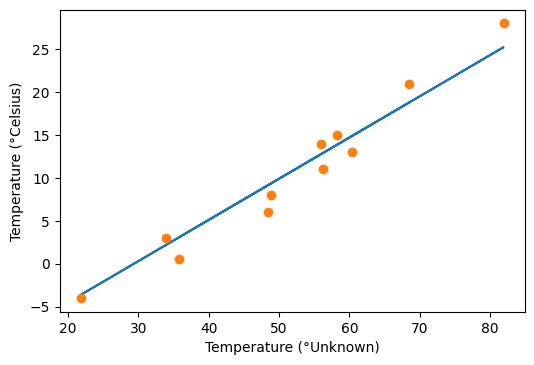

In [38]:
t_p = model(t_un, w_star, b_star)  # <1>

fig = plt.figure(dpi=100)
plt.xlabel("Temperature (°Unknown)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # <2>
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

## PyTorch Autograd

Above we have a simple model where it's easy to write out the derivatives for the loss function and each parameter. However, as model complexity grows, this becomes unwieldy. The good news is PyTorch tensors can remember where they come from and can automatically provide the chain of derivatives from parent operations with respect to their inputs. PyTorch creates an autograd graph of operations that is traversed forward for the forward pass and backwards for the backwards pass to compute the gradients. We can re-write our learning procedure above by taking advantage of this autograd functionality.

In [39]:
# requires_grad=True tells PyTorch to track the entire family tree of tensors resulting from operations on params
# the value of the derivative will be automatically populated as a grad attribute of the params tensor
params = torch.tensor([1.0, 0.0], requires_grad=True)

In [40]:
params.grad

In order to populate the gradient, we start with a tensor with `requires_grad` set to `True`, get the model, compute the loss, then call `backward` on the loss tensor.

In [41]:
loss = mse(model(t_u, *params), t_c)
loss.backward()

In [42]:
loss, params.grad

(tensor(1763.8848, grad_fn=<MeanBackward0>), tensor([4517.2969,   82.6000]))

Now the `grad` attribute of `params` contains the derivatives of the loss with
respect to each element of `params`

It's important to note that calling `backward` causes gradients to accumulate at leaf nodes. In order to update parameters at each iteration of a training loop, they need to be zerod out explicitly after issuing updates. We can do this easily using the in-place `zero_` method

In [43]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()
        
        t_p = model(t_u, *params) 
        loss = mse(t_p, t_c)
        loss.backward()
        
        with torch.no_grad():
            params -= learning_rate * params.grad

        if epoch % 100 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

Above we see the use of `torch.no_grad`. This code block tells PyTorch to update params inplace and not add an edge to the autograd graph. If we were using validation data to track training, computing the loss of the validation data would go in here as well since we wouldn't want to build a graph for that. When using autograd we usually avoid inplace operations as done above because we might need the values we'd modify during the backward pass. Related functionality that can control whether we use autograd or not is `torch.set_grad_enabled(bool)` and is useful to distinguish between training and inference loops

In [44]:
w_star, b_star = training_loop(n_epochs = 1000, learning_rate = 1e-2, 
                               params = torch.tensor([1.0, 0.0], requires_grad=True),
                               t_u = t_un,  
                               t_c = t_c)
w_star, b_star

Epoch 100, Loss 22.148710
Epoch 200, Loss 16.608067
Epoch 300, Loss 12.664559
Epoch 400, Loss 9.857802
Epoch 500, Loss 7.860115
Epoch 600, Loss 6.438284
Epoch 700, Loss 5.426309
Epoch 800, Loss 4.706046
Epoch 900, Loss 4.193405
Epoch 1000, Loss 3.828538


(tensor(4.8021, grad_fn=<UnbindBackward>),
 tensor(-14.1031, grad_fn=<UnbindBackward>))

Gives same result as before when we manually differentiated everything!

## Optimizers

In [45]:
import torch.optim as optim

Above we used vanilla gradient descent, but in practice there are better optimization techniques to deal with more complex models. A list of supported optimization algorithms are listed in [torch.optim](https://pytorch.org/docs/stable/optim.html). Every optimizer constructor takes a list of parameters (aka PyTorch tensors, typically with `requires_grad` set to `True`) as the first input. All parameters passed to the optimizer are retained inside the optimizer object so the optimizer can update their values and access their `grad` attribute. Each optimizer exposes two methods: `zero_grad` and `step`. `zero_grad` zeroes the grad attribute of all the parameters passed to the optimizer upon construction. `step` updates the value of those parameters. We'll use the optimizer package below to update our parameters automatically according to the chosen optimizer and a pre-defined learning rate. We can choose a more sophisticated optimizer with an adaptive learning rate such as Adam.

In [46]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
optimizer = optim.Adam([params], lr=1e-1)

In [47]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = mse(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

In [48]:
training_loop(
    n_epochs = 1000, 
    optimizer = optimizer,
    params = params,
    t_u = t_un,
    t_c = t_c)

Epoch 100, Loss 18.730587
Epoch 200, Loss 8.292550
Epoch 300, Loss 4.275753
Epoch 400, Loss 3.178962
Epoch 500, Loss 2.962302
Epoch 600, Loss 2.931170
Epoch 700, Loss 2.927909
Epoch 800, Loss 2.927659
Epoch 900, Loss 2.927646
Epoch 1000, Loss 2.927647


tensor([  5.3676, -17.3044], requires_grad=True)

The above parameters look an awful lot like those necessary for converting Celsius to Fahrenheit so we can conclude that the unknown unit of temperature is probably Fahrenheit. The exact values would be `w=5.5556` and `b=-17.7778`

# Torch.nn
`torch.nn` provides common neural network layers and other architectural components such as activation and loss functions. Neural network layers are called `modules` in PyTorch. A PyTorch module is a Python class deriving from the `nn.Module` base class. A module can have one or more `Parameter` instances as attributes, which are tensors whose values are optimized during the training process (think `w` and `b` in our linear model).

We'll start by re-writing our linear model with `torch.nn` and then converting it to a neural network.

In [49]:
# split data into 80% training set and 20% validation set
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

t_c.unsqueeze_(1)
t_u.unsqueeze_(1)

t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [50]:
import torch.nn as nn

In [51]:
t_un_val.shape

torch.Size([2, 1])

PyTorch expects the 0th dimension in the tensor to be the number of examples in the batch, hence the `unsqueeze` op above; the size shows 2 examples, each having one input feature. PyTorch enforces batching because it improves performance if we send just enough compute to saturate the computational power of the GPU. It also helps with some models that calculate statistics over its input data - with a larger batch size, the statistics tend to become more meaningful.

Calling an instance of `nn.Module` with a set of arguments ends up calling a method named `forward` within its `__call__` function. The `forward` method is what executes the forward computation, while `__call__` does other rather important chores before and after calling `forward`. So, it is technically possible to call forward directly, and it will produce the same output as `__call__`, but this should not be done from user code. Now we'll no longer need to initialize parameters `w` and `b` as we do above nor will we need our `model` and `mse` functions.

In [52]:
# arguments are number of input features, number of output features, and whether to include a bias (default True)
linear_model = nn.Linear(1, 1)

In [53]:
# forward pass
linear_model(t_un_val)

tensor([[0.8970],
        [1.8425]], grad_fn=<AddmmBackward>)

In [54]:
# linear model contains parameters w and b by default
optimizer = optim.Adam(linear_model.parameters(), lr=1e-1)
linear_model.weight, linear_model.bias

(Parameter containing:
 tensor([[0.4681]], requires_grad=True),
 Parameter containing:
 tensor([-0.7741], requires_grad=True))

In [55]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        
        with torch.no_grad():
            t_p_val = model(t_u_val)
            loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [56]:
training_loop(
    n_epochs = 1000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # using built in loss
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

Epoch 100, Training loss 22.8464, Validation loss 25.7585
Epoch 200, Training loss 12.8624, Validation loss 15.5194
Epoch 300, Training loss 7.0491, Validation loss 8.7951
Epoch 400, Training loss 4.4477, Validation loss 5.1896
Epoch 500, Training loss 3.5104, Validation loss 3.4544
Epoch 600, Training loss 3.2351, Validation loss 2.6654
Epoch 700, Training loss 3.1687, Validation loss 2.3178
Epoch 800, Training loss 3.1557, Validation loss 2.1700
Epoch 900, Training loss 3.1535, Validation loss 2.1106
Epoch 1000, Training loss 3.1533, Validation loss 2.0885


In [57]:
# these are different than the previous training loop since we are now splitting our data
linear_model.weight, linear_model.bias

(Parameter containing:
 tensor([[5.2572]], requires_grad=True),
 Parameter containing:
 tensor([-16.7094], requires_grad=True))

Now we'll replace our linear model with a simple neural network containing a linear module, followed by an activation function, feeding into another linear module (input layer, hidden layer, output layer). The activation functions allow us to learn non-linear relationships between parameters which seems overkill for our problem that was solved using a linear model but it makes it easy to introduce PyTorch concepts. In general, non-linearities allow the output function to have different slopes at different values and values to be concentrated in a certain range which are properties desirable for training.

In [58]:
from collections import OrderedDict

In [59]:
seq_model = nn.Sequential(OrderedDict([
        ("hidden", nn.Linear(1, 8)),
        ("activation", nn.Tanh()),
        ("output", nn.Linear(8, 1))
    ])
)
seq_model

Sequential(
  (hidden): Linear(in_features=1, out_features=8, bias=True)
  (activation): Tanh()
  (output): Linear(in_features=8, out_features=1, bias=True)
)

`nn.Sequential` gives a simple way to concatenate modules. We can specify the modules without the named `OrderedDict` as well but this makes it easier to track later on. We choose dimension 8 for the hidden layer arbitrarily - the dimension of the output layer however, must match so we can matrix multiply `1 x 8 x 8 x 1 -> 1 x 1`. We can inspect our model and look at all of its parameters


In [60]:
for name, param in seq_model.named_parameters():
    print(name, param.numel(), param.shape)

hidden.weight 8 torch.Size([8, 1])
hidden.bias 8 torch.Size([8])
output.weight 8 torch.Size([1, 8])
output.bias 1 torch.Size([1])


In [61]:
# inspect output layer's initialized weights
seq_model.output.weight

Parameter containing:
tensor([[ 0.0730,  0.1601,  0.0291, -0.1636,  0.2347,  0.3223, -0.1034,  0.2086]],
       requires_grad=True)

In [62]:
optimizer = optim.Adam(seq_model.parameters(), lr=1e-2)

In [63]:
training_loop(
    n_epochs = 1000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

Epoch 100, Training loss 85.7229, Validation loss 35.9689
Epoch 200, Training loss 37.0779, Validation loss 8.4389
Epoch 300, Training loss 21.5115, Validation loss 2.4983
Epoch 400, Training loss 12.5073, Validation loss 2.2060
Epoch 500, Training loss 7.5120, Validation loss 2.5850
Epoch 600, Training loss 4.2222, Validation loss 6.9852
Epoch 700, Training loss 2.6850, Validation loss 8.0673
Epoch 800, Training loss 1.9347, Validation loss 8.3633
Epoch 900, Training loss 1.5238, Validation loss 8.4401
Epoch 1000, Training loss 1.2923, Validation loss 8.4277


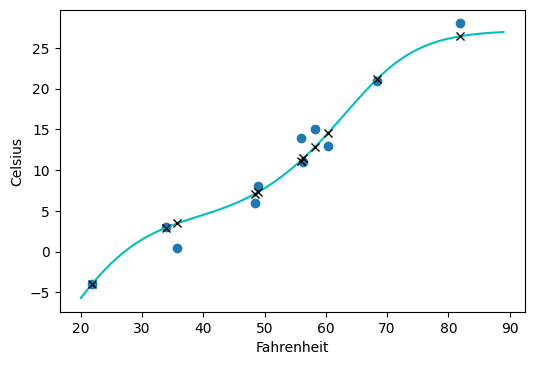

In [64]:
t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=100)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
# blue circles are the unknown temperature (well we sort of know it's fahrenheit)
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
# do a forward pass of all temps 20-90 degrees, normalize by multiplying by 0.1 as we did during training
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
# do a forward pass for inference and mark predicted points with an x
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

Compared to the linear model, the neural network overfits a bit with the s shaped curve above but it's not too bad

When we want to build models that do more complex things than just applying one layer after another, we need to leave `nn.Sequential` for something that gives us added flexibility. PyTorch allows us to use any computation in our model by subclassing `nn.Module`. In order to subclass `nn.Module`, at a minimum we need to define a forward function
that takes the inputs to the module and returns the output (PyTorch automatically takes care of the backward pass with autograd).  Typically, our computation will use other modules—premade like convolutions or customized. Submodules must be top level attributes so that PyTorch can register them. We typically define submodules in the `__init__` and assign them to `self` for use in the forward function. If a collection is needed we can use `nn.ModuleList` or `nn.ModuleDict`. Let's convert the `nn.Sequential` model we defined to a subclass of `nn.Module`

In [65]:
class SubclassFunctionalModel(nn.Module):
    def __init__(self, n_hidden=8):
        super().__init__()
        self.n_hidden = n_hidden
        self.hidden = nn.Linear(1, n_hidden)
        self.output = nn.Linear(n_hidden, 1)
        
    def forward(self, input_):
        hidden_t = self.hidden(input_)
        activated_t = torch.tanh(hidden_t)
        output_t = self.output(activated_t)
        
        return output_t

Above we also make use of PyTorch's functional API available in `torch.nn.functional`. We can replace all submodules that don't have any parameters in favor of their functional counterparts. In this case we keep `nn.Linear` in as modules so that `SubclassFunctionalModel` will be able to manage their parameters during training. Since the `torch.tanh` activation function doesn't have any paremeters, we can just use it directly through the functional API instead of having to intialize it first. We can now move our data and model to the GPU and train it there

In [66]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [67]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        # same training loop as above, just moving data to GPU
        t_u_train = t_u_train.to(device=device)
        t_u_val = t_u_val.to(device=device)
        t_c_train = t_c_train.to(device=device)
        t_c_val = t_c_val.to(device=device)
        
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        
        with torch.no_grad():
            t_p_val = model(t_u_val)
            loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [68]:
net = SubclassFunctionalModel().to(device=device)
# it is good practice to create the Optimizer after moving the parameters to the appropriate device
optimizer = optim.Adam(net.parameters(), lr=1e-2)

In [69]:
training_loop(
    n_epochs = 1000, 
    optimizer = optimizer,
    model = net,
    loss_fn = nn.MSELoss(), # using built in loss
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

Epoch 100, Training loss 73.5727, Validation loss 29.7260
Epoch 200, Training loss 32.9347, Validation loss 5.9493
Epoch 300, Training loss 18.4127, Validation loss 2.8130
Epoch 400, Training loss 10.5109, Validation loss 2.7348
Epoch 500, Training loss 5.7748, Validation loss 5.7041
Epoch 600, Training loss 3.4524, Validation loss 6.7101
Epoch 700, Training loss 2.2990, Validation loss 7.6650
Epoch 800, Training loss 1.7077, Validation loss 8.2975
Epoch 900, Training loss 1.3894, Validation loss 8.3534
Epoch 1000, Training loss 1.2029, Validation loss 8.1462


## Misc

`torch.distributed` and `torch.nn.parallel` offers functionality for distributed training

Both `torchvision.models` and Torch Hub provides pretrained models that anyone can use. Although torchvision is a library, Torch Hub is a repository for third party models that allows the community to share models they've built. User just have to include a `hubconf.py` in their repo and Torch Hub will see it.

In [70]:
from torchvision import models

In [71]:
dir(models)[:5]

['AlexNet', 'DenseNet', 'GoogLeNet', 'GoogLeNetOutputs', 'Inception3']